In [1]:
!pip install category_encoders --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
project_path = '/content/drive/My Drive/data-mining/model/'
if project_path not in sys.path:
    sys.path.append(project_path)
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/data-mining/model/']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from my_pytorch_utils.pytorch_model import PyTorchRegressorWrapper
import xgboost as xgb
import time  # To time the tuning process
from sklearn.inspection import permutation_importance
import warnings

In [5]:
df_train = pd.read_csv('/content/drive/My Drive/data-mining/train_data/train_data_preprocessed_no_outliers.csv')
df_test = pd.read_csv('/content/drive/My Drive/data-mining/train_data/test_data_preprocessed.csv')

In [6]:
len(df_train)

325236

In [7]:
df_train.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,2017.0,missing,gas,48544.0,1FTEW1EFXHKC11214,https://images.craigslist.org/00202_fA8s718RZU...,...,f-150,ford,truck,4wd,8,clean,black,2010-2020,automatic,full-size
1,7315327041,https://sandiego.craigslist.org/nsd/ctd/d/palm...,san diego,https://sandiego.craigslist.org,2018.0,missing,gas,53103.0,5J8YD3H53JL004103,https://images.craigslist.org/00Q0Q_b7u8uPQBQE...,...,mdx,acura,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
2,7310280162,https://albany.craigslist.org/ctd/d/new-lebano...,albany,https://albany.craigslist.org,2016.0,excellent,gas,73394.0,1FT7W2B6XGEA62285,https://images.craigslist.org/00c0c_jcqfcYXhpQ...,...,f-250 super duty,ford,truck,4wd,8,clean,white,2010-2020,automatic,full-size
3,7306277173,https://york.craigslist.org/ctd/d/york-2018-bu...,york,https://york.craigslist.org,2018.0,good,gas,38459.0,5GAERBKW1JJ210810,https://images.craigslist.org/00w0w_36PXCHco1K...,...,enclave essence sport,buick,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
4,7303579544,https://tippecanoe.craigslist.org/cto/d/danvil...,lafayette / west lafayette,https://tippecanoe.craigslist.org,2008.0,excellent,gas,173267.0,NaN,https://images.craigslist.org/00I0I_56zzYCrxDH...,...,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,2000-2010,automatic,full-size


In [9]:
df_test.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,2017.0,missing,gas,48544.0,1FTEW1EFXHKC11214,https://images.craigslist.org/00202_fA8s718RZU...,...,f-150,ford,truck,4wd,8,clean,black,2010-2020,automatic,full-size
1,7315327041,https://sandiego.craigslist.org/nsd/ctd/d/palm...,san diego,https://sandiego.craigslist.org,2018.0,missing,gas,53103.0,5J8YD3H53JL004103,https://images.craigslist.org/00Q0Q_b7u8uPQBQE...,...,mdx,acura,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
2,7310280162,https://albany.craigslist.org/ctd/d/new-lebano...,albany,https://albany.craigslist.org,2016.0,excellent,gas,73394.0,1FT7W2B6XGEA62285,https://images.craigslist.org/00c0c_jcqfcYXhpQ...,...,f-250 super duty,ford,truck,4wd,8,clean,white,2010-2020,automatic,full-size
3,7306277173,https://york.craigslist.org/ctd/d/york-2018-bu...,york,https://york.craigslist.org,2018.0,good,gas,38459.0,5GAERBKW1JJ210810,https://images.craigslist.org/00w0w_36PXCHco1K...,...,enclave essence sport,buick,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
4,7303579544,https://tippecanoe.craigslist.org/cto/d/danvil...,lafayette / west lafayette,https://tippecanoe.craigslist.org,2008.0,excellent,gas,173267.0,NaN,https://images.craigslist.org/00I0I_56zzYCrxDH...,...,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,2000-2010,automatic,full-size


In [ ]:
coloums_to_drop = ['url', 'county', 'lat', 'long', 'region_url', 'posting_date', 'VIN', 'image_url', 'description', 'id', 'year_range']
df_train = df_train.drop(columns=coloums_to_drop, inplace=True)

In [ ]:
df_train.head()

In [10]:
# Make a copy for EDA to avoid altering the original df_train used for modeling pipeline
df_eda = df_train.copy()

In [11]:
# Define numerical and categorical columns based on your dataset inspection and modeling choices
# Note: 'price' is the target, 'year' and 'odometer' are numerical predictors.
numerical_eda_cols = ['price', 'year', 'odometer']
categorical_eda_cols = ['cylinders', 'manufacturer', 'fuel', 'drive', 'transmission', 'type', 'condition', 'size', 'title_status', 'paint_color']
# 'region', 'state', 'model' are very high cardinality, requires special handling (e.g., top N, aggregation)


--- 1. Numerical Feature Correlation ---


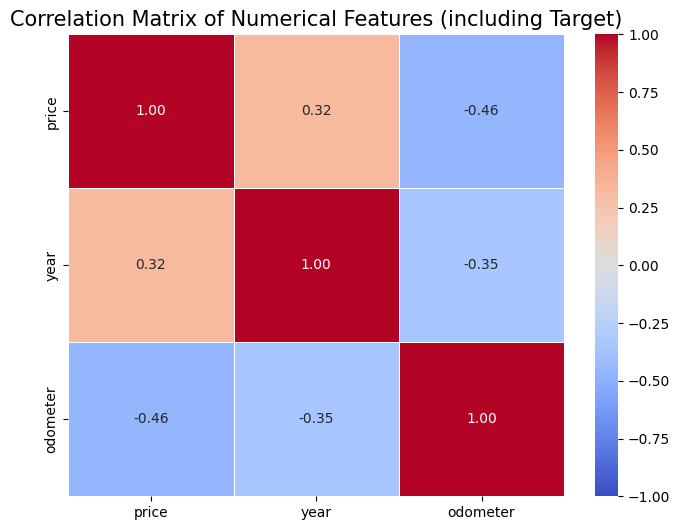


Observations from numerical correlation:
- Price and Year: Positive correlation (newer cars tend to be more expensive).
- Price and Odometer: Negative correlation (cars with more miles tend to be cheaper).
- Year and Odometer: Moderate negative correlation (older cars tend to have more miles).



In [12]:
# 1. Numerical Feature Correlation
print("--- 1. Numerical Feature Correlation ---")
plt.figure(figsize=(8, 6))
numerical_corr = df_eda[numerical_eda_cols].corr()
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features (including Target)", fontsize=15)
plt.show()
print("\nObservations from numerical correlation:")
print("- Price and Year: Positive correlation (newer cars tend to be more expensive).")
print("- Price and Odometer: Negative correlation (cars with more miles tend to be cheaper).")
print("- Year and Odometer: Moderate negative correlation (older cars tend to have more miles).\n")


<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


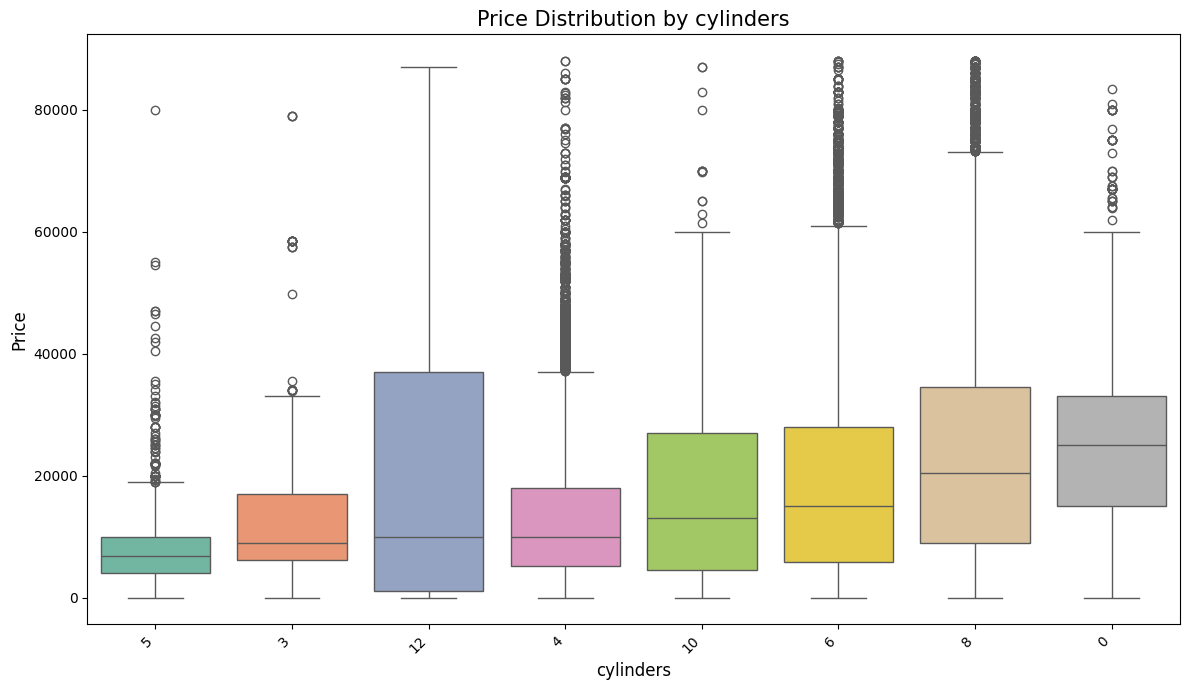

Median price by cylinders:
cylinders
0     24990.0
8     20500.0
6     14999.0
10    12995.0
4      9999.0
12     9995.0
3      8990.0
5      6800.0
Name: price, dtype: float64



<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


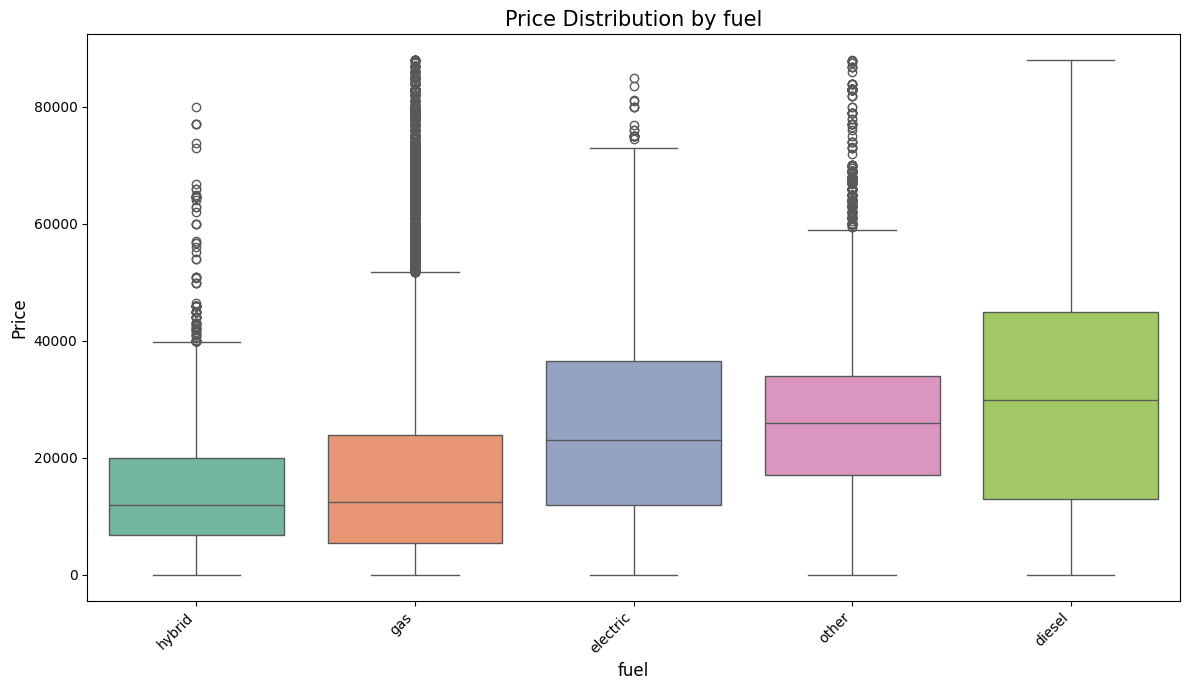

Median price by fuel:
fuel
diesel      29900.0
other       25990.0
electric    22995.0
gas         12490.0
hybrid      11995.0
Name: price, dtype: float64



<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


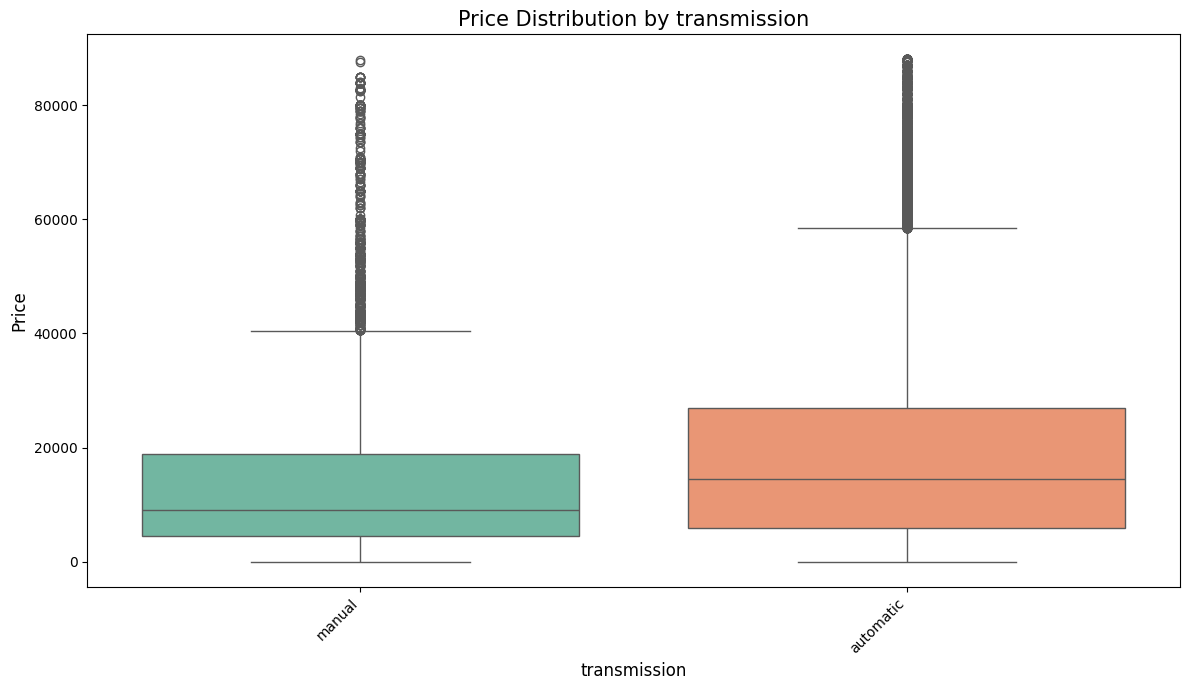

Median price by transmission:
transmission
automatic    14500.0
manual        9000.0
Name: price, dtype: float64



<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


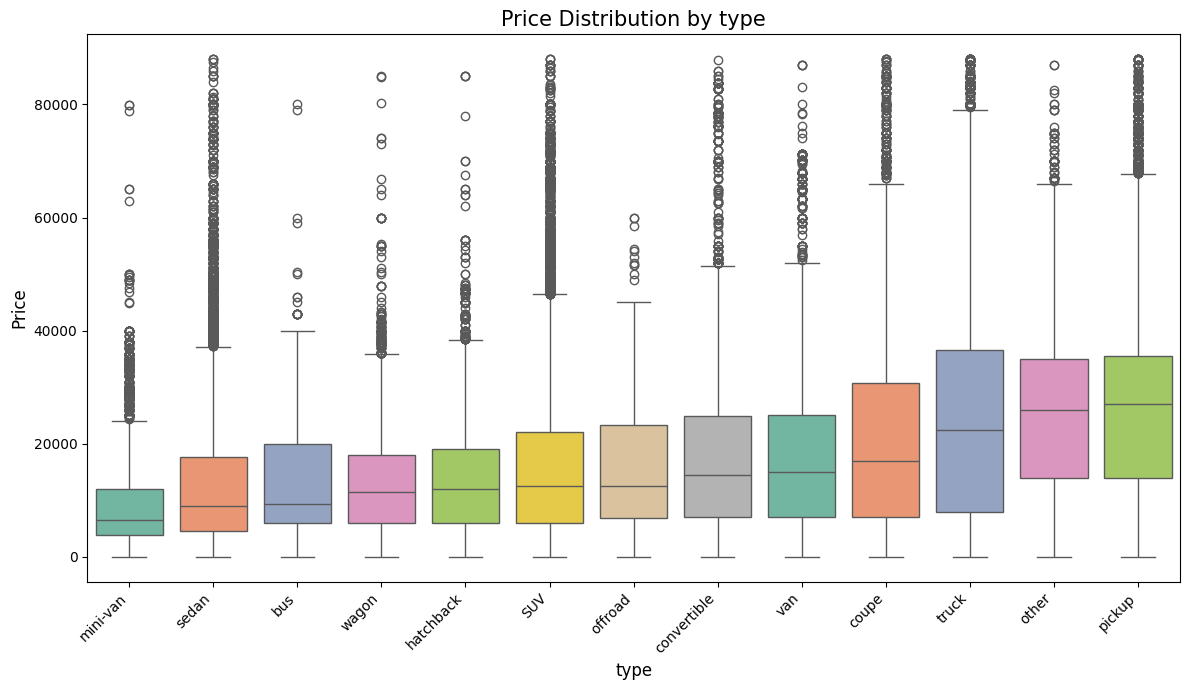

Median price by type:
type
pickup         26988.0
other          25990.0
truck          22500.0
coupe          17000.0
van            14997.0
convertible    14388.0
offroad        12500.0
SUV            12500.0
hatchback      11998.0
wagon          11452.0
bus             9250.0
sedan           8995.0
mini-van        6500.0
Name: price, dtype: float64



<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


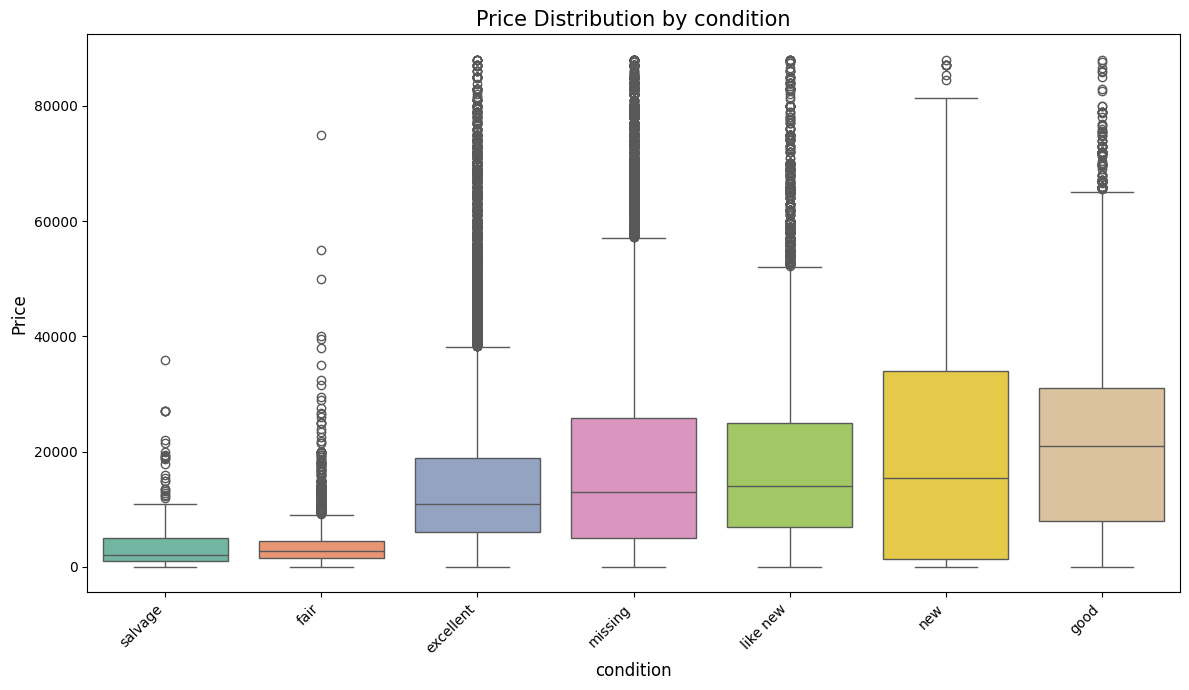

Median price by condition:
condition
good         20986.0
new          15400.0
like new     13995.0
missing      12999.0
excellent    10995.0
fair          2750.0
salvage       1999.0
Name: price, dtype: float64



<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


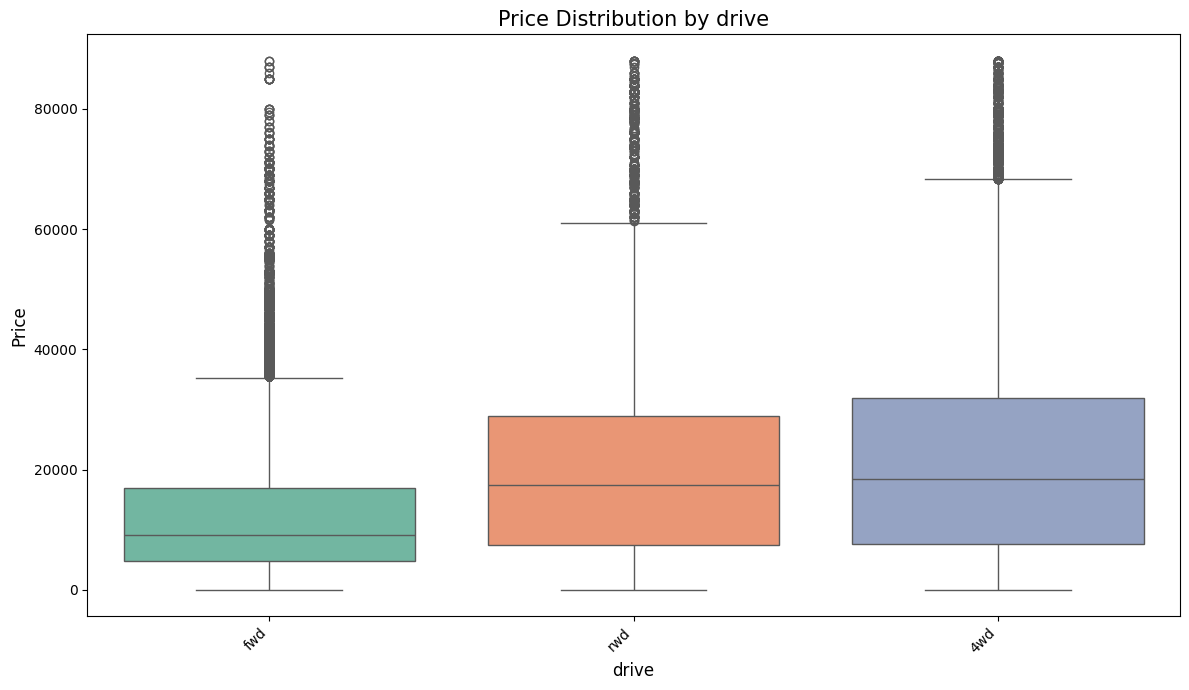

Median price by drive:
drive
4wd    18500.0
rwd    17500.0
fwd     9100.0
Name: price, dtype: float64



<ipython-input-13-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


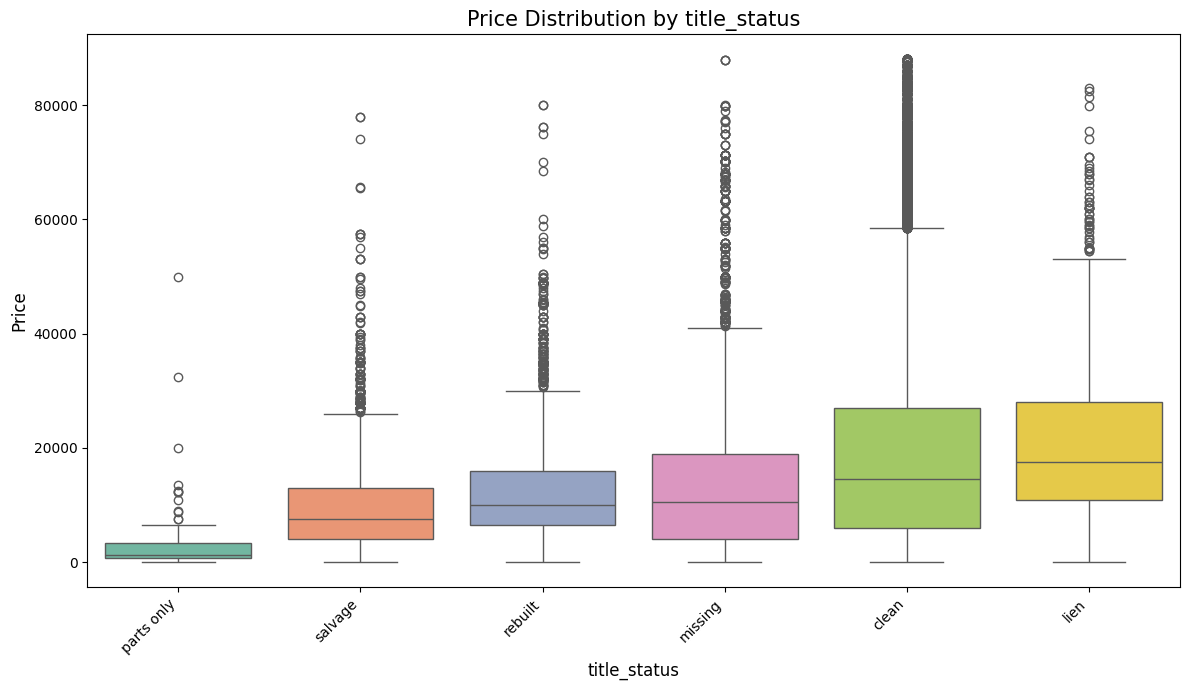

Median price by title_status:
title_status
lien          17500.0
clean         14499.0
missing       10495.0
rebuilt       10000.0
salvage        7500.0
parts only     1325.0
Name: price, dtype: float64


--- Example: Price by Top N Manufacturers ---


<ipython-input-13-3fdcfeed5ed5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='manufacturer', y='price', data=df_top_manu, order=manu_order, palette="viridis")


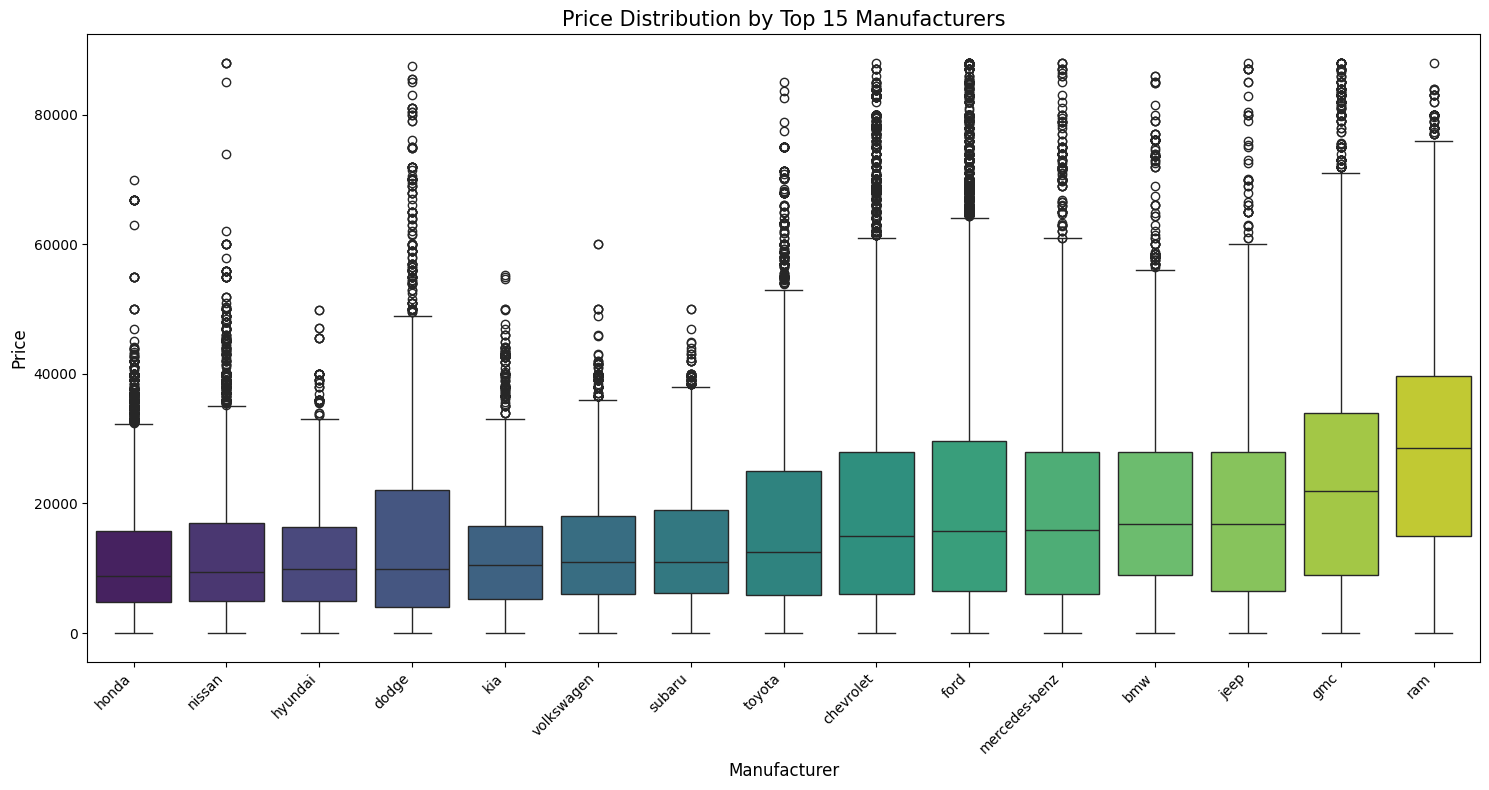

Median price by Top 15 Manufacturers (sorted by median price):
manufacturer
ram              28590.0
gmc              21990.0
jeep             16900.0
bmw              16825.0
mercedes-benz    15900.0
ford             15695.0
chevrolet        14900.0
toyota           12500.0
subaru           10995.0
volkswagen       10995.0
kia              10572.0
dodge             9900.0
hyundai           9877.0
nissan            9442.0
honda             8795.0
Name: price, dtype: float64



In [13]:
# 2. Categorical Features vs. Target (Price)
# Select a subset of categorical features for detailed plotting to avoid clutter
# Features with low to moderate cardinality are good candidates
cat_cols_for_price_boxplot = ['cylinders', 'fuel', 'transmission', 'type', 'condition', 'drive', 'title_status']

for col in cat_cols_for_price_boxplot:

    # To make boxplots more readable, order categories by median price
    order = df_eda.groupby(col)['price'].median().sort_values().index

    plt.figure(figsize=(12, 7))
    sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")
    plt.title(f'Price Distribution by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Display median prices for reference
    print(f"Median price by {col}:\n{df_eda.groupby(col)['price'].median().sort_values(ascending=False)}\n")

# Example for a high-cardinality feature: Manufacturer (Top N by count)
print("\n--- Example: Price by Top N Manufacturers ---")
top_n = 15
top_manufacturers = df_eda['manufacturer'].value_counts().nlargest(top_n).index
df_top_manu = df_eda[df_eda['manufacturer'].isin(top_manufacturers)]

# Order by median price
manu_order = df_top_manu.groupby('manufacturer')['price'].median().sort_values().index

plt.figure(figsize=(15, 8))
sns.boxplot(x='manufacturer', y='price', data=df_top_manu, order=manu_order, palette="viridis")
plt.title(f'Price Distribution by Top {top_n} Manufacturers', fontsize=15)
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"Median price by Top {top_n} Manufacturers (sorted by median price):\n{df_top_manu.groupby('manufacturer')['price'].median().sort_values(ascending=False)}\n")


<ipython-input-14-54d9d22cf423>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


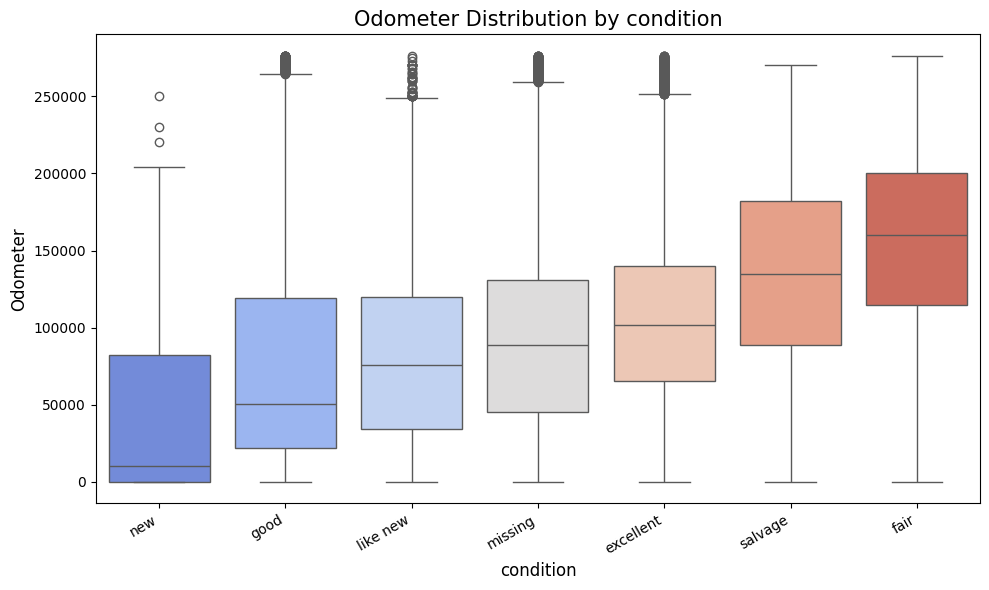

Median odometer by condition:
condition
fair         160225.0
salvage      134584.0
excellent    102000.0
missing       88455.5
like new      76000.0
good          50252.0
new           10000.0
Name: odometer, dtype: float64



<ipython-input-14-54d9d22cf423>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


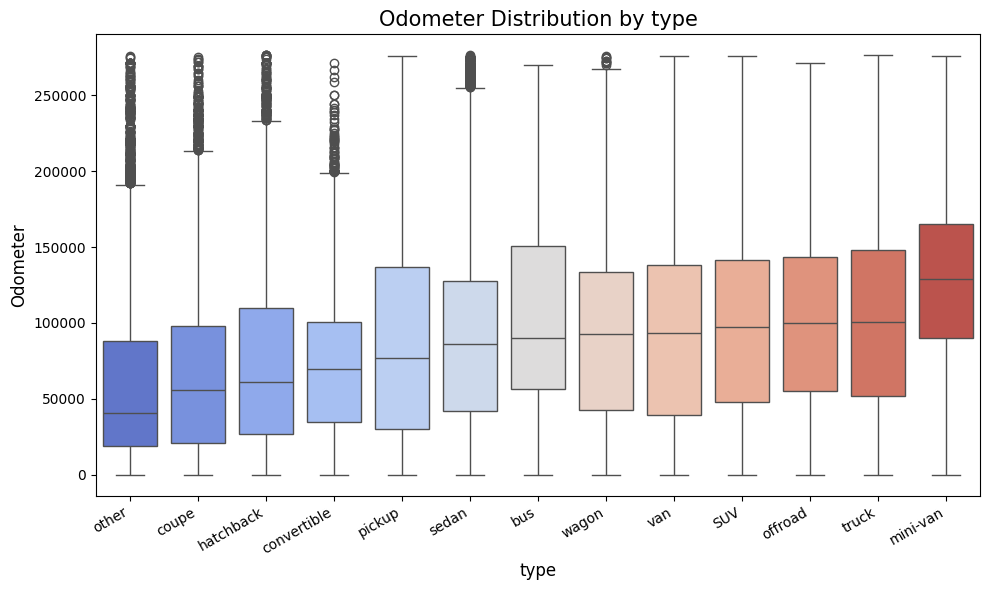

Median odometer by type:
type
mini-van       128878.0
truck          100706.0
offroad        100000.0
SUV             97617.0
van             93450.0
wagon           93000.0
bus             90000.0
sedan           86000.0
pickup          77022.0
convertible     69451.0
hatchback       60984.0
coupe           56075.0
other           40405.0
Name: odometer, dtype: float64



<ipython-input-14-54d9d22cf423>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


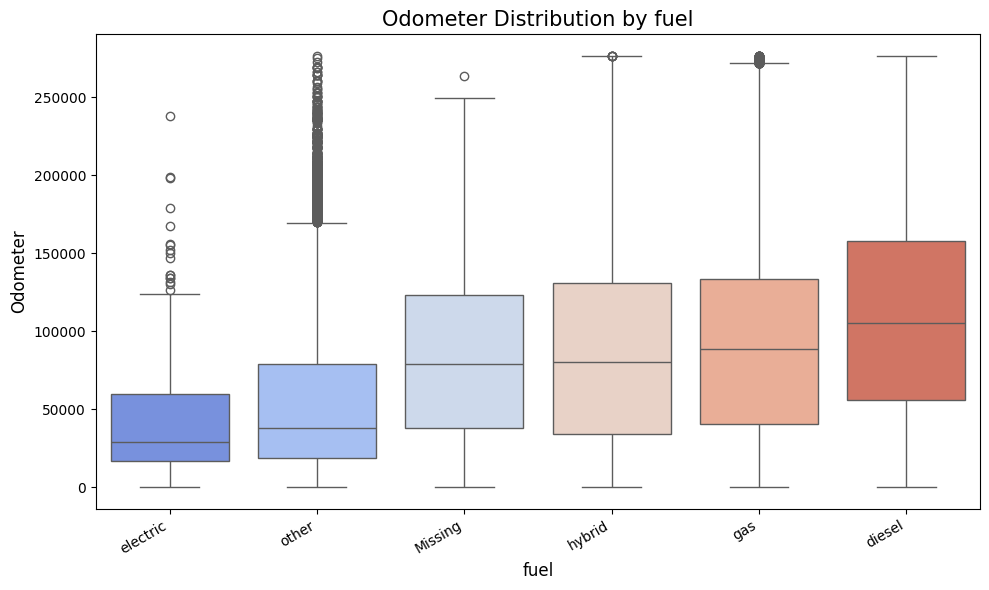

Median odometer by fuel:
fuel
diesel      105000.0
gas          88692.0
hybrid       80000.0
Missing      78699.0
other        37647.0
electric     28805.0
Name: odometer, dtype: float64



In [14]:
# 3. Categorical Features vs. Another Numerical Feature (e.g., Odometer)
cat_cols_for_odo_boxplot = ['condition', 'type', 'fuel'] # Example features

for col in cat_cols_for_odo_boxplot:
    df_eda[col] = df_eda[col].fillna('Missing') # Ensure NaNs are handled for plotting
    order = df_eda.groupby(col)['odometer'].median().sort_values().index # Order by median odometer

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")
    # Filter out extreme odometer outliers for better visualization if necessary
    # sns.boxplot(x=col, y='odometer', data=df_eda[df_eda['odometer'] < df_eda['odometer'].quantile(0.99)], order=order)
    plt.title(f'Odometer Distribution by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Odometer', fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"Median odometer by {col}:\n{df_eda.groupby(col)['odometer'].median().sort_values(ascending=False)}\n")



In [15]:
print(f"Original train shape: {df_train.shape}")
df_train = df_train[df_train['price'] > 0].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Train shape after removing price <= 0: {df_train.shape}")

Original train shape: (325236, 27)
Train shape after removing price <= 0: (301498, 27)


In [16]:
print(f"Original test shape: {df_test.shape}")
df_test = df_test[df_test['price'] > 0].copy()
print(f"Test shape after removing price <= 0: {df_test.shape}")

Original test shape: (81184, 27)
Test shape after removing price <= 0: (75359, 27)


In [17]:
# 2. Define X and y
X_train_df = df_train.drop(columns=['price'])
y_train_original = df_train['price'] # Keep original for final evaluation comparison if needed

X_test_df = df_test.drop(columns=['price'])
y_test_original = df_test['price']   # This will be our final reference for y_test


In [18]:
# 3. Apply log transformation to y_train for model fitting
y_train_log = np.log(y_train_original)
# We will use y_test_original for final evaluation after inverse transforming predictions.
# y_test_log is not directly used by the model fitting/tuning loop for y.
print(f"\nTarget variable 'price' log-transformed for training.")
print(f"y_train_original mean: {y_train_original.mean():.2f}, std: {y_train_original.std():.2f}")
print(f"y_train_log mean: {y_train_log.mean():.2f}, std: {y_train_log.std():.2f}")



Target variable 'price' log-transformed for training.
y_train_original mean: 18758.62, std: 14203.02
y_train_log mean: 9.42, std: 1.22


In [19]:
X_train = X_train_df
y_train = y_train_log
X_test = X_test_df

In [20]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
thinc 8.3.6 

In [21]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [22]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from pygam import LinearGAM

# Define columns
cat_columns = ['cylinders', 'manufacturer', 'state', 'model', 'fuel', 'drive', 'transmission', 'type', 'condition', 'size', 'title_status', 'paint_color' ]
num_columns = ['year', 'odometer']

# Create proper preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer([
    # For categorical features, split by encoding typ
    ('region_enc', Pipeline([
        ('encoder', ce.BinaryEncoder())
    ]), ['region']),

    ('freq_enc', Pipeline([
        ('encoder', ce.CountEncoder())
    ]), ['manufacturer', 'state', 'model']),

    ('onehot_enc', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), ['fuel', 'drive', 'transmission', 'type', 'title_status', 'paint_color', 'cylinders']),

    ('ordinal_enc', Pipeline([
        ('encoder', OrdinalEncoder())
    ]), ['condition', 'size']),

    # For numerical features
    ('num', Pipeline([
        ('scaler', StandardScaler())
    ]), num_columns)
], remainder='drop')


# Dictionary of regressors
model_pipelines = {
    # --- Linear Models ---
   'linear_simple': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression(n_jobs=-1),)
    ]),
    'linear_poly': Pipeline([
        ('preprocessor', preprocessor),
        ('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    #'knn': Pipeline([
        #('preprocessor', preprocessor),
        #('regressor', KNeighborsRegressor(n_jobs=-1))
    #]),
    #'ridge': Pipeline([ # NEW: Simple Ridge
        #('preprocessor', preprocessor),
        #('regressor', Ridge(random_state=42)) # alpha will be tuned
   # ]),
    #'ridge_poly': Pipeline([ # NEW: Polynomial Ridge
       # ('preprocessor', preprocessor),
       # ('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
       # ('regressor', Ridge(random_state=42)) # alpha will be tuned
  # ]),
    #'lasso': Pipeline([ # NEW: Simple Lasso
        #('preprocessor', preprocessor),
        #('regressor', Lasso(random_state=42)) # alpha will be tuned
   # ]),
  #  #'lasso_poly': Pipeline([ # NEW: Polynomial Lasso
        #('preprocessor', preprocessor),
        #('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
       # ('regressor', Lasso(random_state=42)) # alpha will be tuned
 #   ]),
    #'gam': Pipeline([ # NEW: Generalized Additive Models
       # ('preprocessor', preprocessor),
       # ('regressor', LinearGAM())
   # ]),
    #'svr': Pipeline([
      #  ('preprocessor', preprocessor),
      #  ('regressor', SVR()) # Note: SVR is computationally expensive, esp. with many features (like from poly)
  #  ]),
    'dt': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'rf': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
   # 'gb': Pipeline([ # NEW: gradBoost
    #    ('preprocessor', preprocessor),
     #   ('regressor', HistGradientBoostingRegressor(random_state=42))
   # ]),
    'xgb': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')),
    ]),
    #'pytorch_linear': Pipeline([
       # ('preprocessor', preprocessor), # Use the SAME preprocessor!
       # ('regressor', PyTorchRegressorWrapper(lr=0.01, epochs=50, batch_size=64)) # Adjust hyperparameters
   # ])
}

In [23]:
import numpy as np
from scipy.stats import loguniform, uniform, randint
from sklearn.model_selection import RandomizedSearchCV
# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    # --- Linear Models ---
    'linear_simple': {
        'regressor__fit_intercept': [True],
    },
    'linear_poly': {
        'poly_features__degree': [2], # Just test degree 2 initially
        'regressor__fit_intercept': [True],
    },
    'ridge': {
        'regressor__alpha': loguniform(1e-2, 1e1), # Narrower range for alpha
        'regressor__fit_intercept': [True],
        # 'regressor__solver': ['auto', 'svd', ...], # Removed solver tuning for simplicity
    },
    'ridge_poly': {
        'poly_features__degree': [2],
        'regressor__alpha': loguniform(1e-2, 1e1),
        'regressor__fit_intercept': [True],
    },
    'lasso': {
        'regressor__alpha': loguniform(1e-3, 1e0), # Narrower range
        'regressor__max_iter': [1000, 2000],      # Fewer choices for max_iter
        'regressor__fit_intercept': [True]
    },
    'lasso_poly': {
        'poly_features__degree': [2],
        'regressor__alpha': loguniform(1e-3, 1e0),
        'regressor__max_iter': [1000, 2000],
        'regressor__fit_intercept': [True]
    },
    'knn': {
        'regressor__n_neighbors': randint(3, 20), # Number of neighbors (e.g., 3 to 19)
        'regressor__weights': ['uniform', 'distance'], # How to weight neighbors
        'regressor__p': [1, 2] # Power parameter for Minkowski distance: 1 for Manhattan, 2 for Euclidean
        # 'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] # Usually 'auto' is fine
        # 'regressor__leaf_size': randint(20, 41) # For BallTree or KDTree, less critical usually
    },
    'gam': {
        'regressor__n_splines': randint(8, 16),   # Fewer splines
        'regressor__lam': loguniform(1e-2, 1e1), # Narrower lambda
    },
    'svr': {
        'regressor__C': loguniform(1e0, 1e2),      # Narrower C
        'regressor__epsilon': [0.1, 0.01],         # Fewer epsilon choices
        'regressor__gamma': loguniform(1e-3, 1e-2),# Narrower gamma
        'regressor__kernel': ['rbf']              # Focus on rbf kernel initially
    },
    'dt': {
        'regressor__max_depth': [5, 10, 15, None], # Fewer depth options
        'regressor__min_samples_split': randint(5, 16), # Narrower range
        'regressor__min_samples_leaf': randint(5, 16),  # Narrower range
        'regressor__max_features': ['sqrt', 0.7],     # Fewer options
        # 'regressor__ccp_alpha': loguniform(1e-4, 1e-1) # Can remove ccp_alpha for quicker DT
    },
    'rf': { # Parameters already adjusted for lower memory in previous discussion
        'regressor__n_estimators': randint(50, 101),      # Fewer estimators
        'regressor__max_depth': list(range(5, 13, 3)),   # Shallower: [5, 8, 11]
        'regressor__min_samples_split': randint(10, 31), # Higher min samples
        'regressor__min_samples_leaf': randint(10, 31),  # Higher min samples
        'regressor__max_features': ['sqrt'],             # Just 'sqrt'
        'regressor__bootstrap': [True],
        # 'regressor__ccp_alpha': loguniform(1e-3, 1e-1) # Can remove for quicker RF
    },
    'gb': {
        'regressor__n_estimators': randint(50, 151),     # Fewer estimators
        'regressor__learning_rate': loguniform(0.01, 0.1),# Narrower learning rate
        'regressor__max_depth': [3, 5, 7],              # Fewer depth choices
        'regressor__min_samples_split': randint(5, 16),
        'regressor__min_samples_leaf': randint(5, 16),
        'regressor__max_features': ['sqrt'],
        'regressor__subsample': [0.7, 0.8, 0.9],        # Discrete subsample options
    },
    'xgb': {
        'regressor__n_estimators': randint(50, 151),
        'regressor__learning_rate': loguniform(0.01, 0.1),
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_child_weight': [1, 3, 5],
        'regressor__subsample': [0.7, 0.8],
        'regressor__colsample_bytree': [0.7, 0.8],
        # 'regressor__colsample_bylevel': uniform(0.5, 0.5), # Removed for simplicity
        # 'regressor__gamma': loguniform(1e-3, 5.0),       # Removed for simplicity
        # 'regressor__reg_alpha': loguniform(1e-3, 5.0),   # Removed for simplicity
        # 'regressor__reg_lambda': loguniform(1e-3, 10.0)  # Removed for simplicity
    },
    'pytorch_linear': {
        'regressor__lr': loguniform(1e-3, 1e-2), # Narrower LR
        'regressor__epochs': randint(20, 51),   # Fewer epochs
        'regressor__batch_size': [64, 128]      # Fewer batch sizes
    }
}

In [29]:
from tqdm.auto import tqdm
from sklearn.base import clone
# %% Your tune_model function (no changes needed here, it will receive y_train_log)
def tune_model(X_train_data, y_train_data, model_name_str, pipeline_to_tune, param_dist_dict, cv=5, n_iter=100, error_score_val=np.nan):
    print(f"--- Tuning {model_name_str} (target is log-transformed) ---")
    start_time_tune = time.time()

    random_search = RandomizedSearchCV(
        estimator=pipeline_to_tune,
        param_distributions=param_dist_dict,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_squared_error', # This will be on log(price)
        n_jobs=-1,
        verbose=1,
        random_state=42,
        return_train_score=True,
        error_score=error_score_val
    )
    try:
        with parallel_backend('threading'):
          random_search.fit(X_train_data, y_train_data)
    except Exception as e:
        print(f"An error occurred during RandomizedSearchCV for {model_name_str}: {e}")
        print(f"Skipping further processing for {model_name_str}.")
        return None

    end_time_tune = time.time()
    elapsed_time_tune = end_time_tune - start_time_tune
    print(f"\nFinished tuning {model_name_str} in {elapsed_time_tune:.2f} seconds.")

    if hasattr(random_search, 'best_params_') and random_search.best_params_:
        print(f"Best parameters found for {model_name_str}:")
        best_params_cleaned = {k.split('__', 1)[1] if '__' in k else k: v for k, v in random_search.best_params_.items()}
        print(best_params_cleaned)
        best_cv_log_mse = -random_search.best_score_ # MSE of log(price)
        best_cv_log_rmse = np.sqrt(best_cv_log_mse)  # RMSE of log(price)
        print(f"Best CV score (MSE of log-price): {best_cv_log_mse:,.4f}")
        print(f"Best CV score (RMSE of log-price): {best_cv_log_rmse:,.4f}")
    else:
        print(f"RandomizedSearchCV for {model_name_str} did not find successful fits.")
    print("-------------------------")
    return random_search.best_estimator_


In [30]:
from sklearn.base import clone
from joblib import parallel_backend
from tqdm.auto import tqdm # Import tqdm
n_iterations = 50 # REDUCED for quicker testing; use your original 50 for full run
cv_folds = 5      # REDUCED for quicker testing; use your original 5 for full run

best_models_log_target = {} # Use a new dictionary name to avoid confusion

print(f"Starting hyperparameter tuning with n_iter={n_iterations} and cv={cv_folds} folds (target is log-transformed).\n")

# Pass X_train and y_train (which is y_train_log)
for model_name, pipeline_obj in tqdm(model_pipelines.items(), desc="Overall Model Tuning (Log Target)", unit="model"):
    # It's generally good practice to clone, especially if preprocessor has fit state
    # that shouldn't carry over if something went wrong in a previous iteration (though less critical here).
    current_pipeline_instance = clone(pipeline_obj)

    if model_name in param_distributions:
        best_models_log_target[model_name] = tune_model(
            X_train, y_train, model_name, current_pipeline_instance, # y_train is y_train_log
            param_distributions[model_name], cv=cv_folds, n_iter=n_iterations
        )
    else:
        print(f"--- Training {model_name} (no tuning, target is log-transformed) ---")
        start_time_fit = time.time()
        try:
            current_pipeline_instance.fit(X_train, y_train) # y_train is y_train_log
            best_models_log_target[model_name] = current_pipeline_instance
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            best_models_log_target[model_name] = None
        end_time_fit = time.time()
        print(f"Finished training {model_name} in {end_time_fit - start_time_fit:.2f} seconds.")
        print("-------------------------")

print("\n--- All Tuning and Training with Log-Transformed Target Complete ---")
for model_name, model_instance in best_models_log_target.items():
    if model_instance:
        print(f"Best model for {model_name} (trained on log-target): Retrieved successfully.")
    else:
        print(f"Training/Tuning failed for {model_name} (trained on log-target).")

Starting hyperparameter tuning with n_iter=50 and cv=5 folds (target is log-transformed).



Overall Model Tuning (Log Target):   0%|          | 0/5 [00:00<?, ?model/s]

--- Tuning linear_simple (target is log-transformed) ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Finished tuning linear_simple in 15.00 seconds.
Best parameters found for linear_simple:
{'fit_intercept': True}
Best CV score (MSE of log-price): 1.0551
Best CV score (RMSE of log-price): 1.0272
-------------------------
--- Tuning linear_poly (target is log-transformed) ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Finished tuning linear_poly in 251.66 seconds.
Best parameters found for linear_poly:
{'fit_intercept': True, 'degree': 2}
Best CV score (MSE of log-price): 0.9150
Best CV score (RMSE of log-price): 0.9565
-------------------------
--- Tuning dt (target is log-transformed) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Finished tuning dt in 522.92 seconds.
Best parameters found for dt:
{'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 10, 'min_samples_split': 13}
Best CV score (MSE of log-price): 0.6881
Best CV score (RMSE of log-price): 0.8295
-------------------------
--- Tuning rf (target is log-transformed) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Finished tuning rf in 993.26 seconds.
Best parameters found for rf:
{'bootstrap': True, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 54}
Best CV score (MSE of log-price): 0.8532
Best CV score (RMSE of log-price): 0.9237
-

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
results_log_target = []

# Use y_test_original for evaluating final price predictions
if 'best_models_log_target' in locals() and best_models_log_target and 'X_test' in locals() and 'y_test_original' in locals():
    print("\n--- Evaluating models trained on log-transformed target ---")
    print("--- Metrics are calculated on the ORIGINAL price scale after inverse transformation ---")

    for name, model in best_models_log_target.items():
        if model is None:
            print(f"Skipping evaluation for {name} as it was not trained successfully.")
            results_log_target.append({
                'Model': name, 'Test MAE': np.nan, 'Test MedAE': np.nan,
                'Test MSE': np.nan, 'Test RMSE': np.nan, 'Test R2 Score': np.nan,
                'Evaluation Time (s)': 0, 'Note': 'Model training failed'
            })
            continue

        print(f"\nEvaluating {name}...")
        start_time_eval = time.time()

        try:
            # 1. Predict on X_test (predictions will be in log scale)
            log_predictions = model.predict(X_test)

            # 2. Inverse transform predictions to original price scale
            final_predictions = np.exp(log_predictions)

            # Optional: Sanity check/clip predictions if exp() leads to extreme values or NaNs
            # This might happen if log_predictions are extremely large/small or NaN.
            if np.isnan(final_predictions).any() or np.isinf(final_predictions).any():
                print(f"  Warning: NaNs or Infs in final_predictions for {name}. Applying nan_to_num and clipping.")
                # Replace NaNs with median of y_test_original, Infs with a large value based on y_test_original
                median_y_test = np.median(y_test_original)
                max_y_test = np.max(y_test_original)
                final_predictions = np.nan_to_num(final_predictions, copy=False, nan=median_y_test,
                                                  posinf=max_y_test * 5, neginf=1.0) # neginf to small positive if prices can't be <1

            # Clip predictions to a reasonable range (e.g., min observed price, max observed price * factor)
            min_price_observed = y_test_original.min() if len(y_test_original) > 0 else 1
            max_price_cap = y_test_original.max() * 5 if len(y_test_original) > 0 else 1e9 # Cap at 5x max observed
            final_predictions = np.clip(final_predictions, min_price_observed, max_price_cap)


        except Exception as e:
            print(f"  Error predicting or transforming with {name}: {e}")
            results_log_target.append({
                'Model': name, 'Test MAE': np.nan, 'Test MedAE': np.nan,
                'Test MSE': np.nan, 'Test RMSE': np.nan, 'Test R2 Score': np.nan,
                'Evaluation Time (s)': time.time() - start_time_eval, 'Note': f'Prediction/Transform error: {e}'
            })
            print("-" * 20)
            continue

        # Ensure y_test_original and final_predictions are 1D arrays for metrics
        y_test_eval = np.array(y_test_original).ravel()
        y_pred_eval = np.array(final_predictions).ravel()

        if len(y_test_eval) != len(y_pred_eval):
            print(f"  Shape mismatch: y_test_original has {len(y_test_eval)} samples, final_predictions has {len(y_pred_eval)} for model {name}.")
            # ... (append nan results)
            continue

        # 3. Calculate evaluation metrics on the ORIGINAL price scale
        mae = mean_absolute_error(y_test_eval, y_pred_eval)
        medae = median_absolute_error(y_test_eval, y_pred_eval)
        mse = mean_squared_error(y_test_eval, y_pred_eval)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_eval, y_pred_eval) # R2 can be sensitive to transformations

        end_time_eval = time.time()
        eval_time = end_time_eval - start_time_eval

        results_log_target.append({
            'Model': name,
            'Test MAE': mae, 'Test MedAE': medae,
            'Test MSE': mse, 'Test RMSE': rmse,
            'Test R2 Score': r2,
            'Evaluation Time (s)': eval_time,
            'Note': 'Log-transformed target'
        })

        print(f"  Test MAE (original scale): {mae:,.2f}") # Format for currency
        print(f"  Test MedAE (original scale): {medae:,.2f}")
        print(f"  Test MSE (original scale): {mse:,.2f}")
        print(f"  Test RMSE (original scale): {rmse:,.2f}")
        print(f"  Test R² Score (original scale): {r2:.4f}")
        print(f"  Evaluation Time: {eval_time:.2f} seconds")
        print("-" * 20)

    if results_log_target:
        results_log_df = pd.DataFrame(results_log_target)
        print("\n--- Overall Test Set Results (Models trained on log-target, evaluated on original scale) ---")
        print(results_log_df.to_string(index=False))
        results_log_df.to_csv('model_evaluation_results_log_target.csv', index=False)
        print("\nLog-target model evaluation results saved to 'model_evaluation_results_log_target.csv'")
    else:
        print("\nNo models (trained on log-target) were successfully evaluated.")
        results_log_df = pd.DataFrame()

else:
    print("Error: 'best_models_log_target' or other necessary data not found for evaluation.")
    results_log_df = pd.DataFrame() # Ensure results_log_df exists


--- Evaluating models trained on log-transformed target ---
--- Metrics are calculated on the ORIGINAL price scale after inverse transformation ---

Evaluating linear_simple...
  Test MAE (original scale): 6,596.83
  Test MedAE (original scale): 4,163.83
  Test MSE (original scale): 95,676,916.17
  Test RMSE (original scale): 9,781.46
  Test R² Score (original scale): 0.5267
  Evaluation Time: 0.25 seconds
--------------------

Evaluating linear_poly...
  Test MAE (original scale): 6,139.54
  Test MedAE (original scale): 3,729.78
  Test MSE (original scale): 94,941,150.12
  Test RMSE (original scale): 9,743.77
  Test R² Score (original scale): 0.5303
  Evaluation Time: 1.65 seconds
--------------------

Evaluating dt...
  Test MAE (original scale): 3,959.67
  Test MedAE (original scale): 1,889.27
  Test MSE (original scale): 52,973,748.84
  Test RMSE (original scale): 7,278.31
  Test R² Score (original scale): 0.7379
  Evaluation Time: 0.33 seconds
--------------------

Evaluating rf.

In [33]:
# Define the path for the results CSV file
results_csv_path = '/content/drive/My Drive/data-mining/model_results/model_evaluation_results.csv'

try:
    # Save the DataFrame to a CSV file
    results_log_df.to_csv(results_csv_path, index=False)
    print(f"\nEvaluation results saved successfully to: {results_csv_path}")
except Exception as e:
    print(f"\nError saving results to CSV: {e}")


Evaluation results saved successfully to: /content/drive/My Drive/data-mining/model_results/model_evaluation_results.csv



Calculating permutation importance for: xgb (trained on log-target)
Permutation importance calculation time: 80.31 seconds

Top 15 Original Features for xgb (Permutation Importance on Test Set):
Importance = Mean drop in 'neg_mean_squared_error' of log(price).


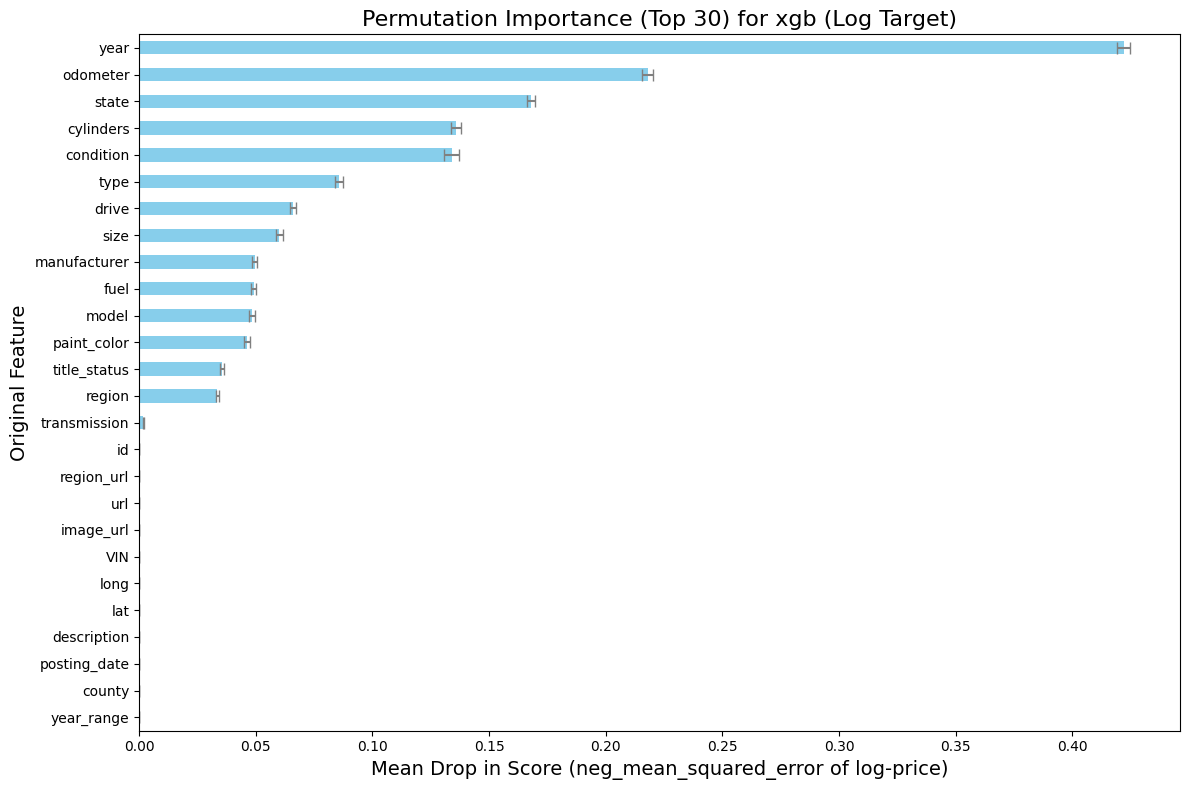

In [36]:
from sklearn.inspection import permutation_importance
model_to_inspect_name_log = 'xgb' # Or 'rf', etc.
if model_to_inspect_name_log in best_models_log_target and best_models_log_target[model_to_inspect_name_log]:
    fitted_pipeline_log = best_models_log_target[model_to_inspect_name_log]
    print(f"\nCalculating permutation importance for: {model_to_inspect_name_log} (trained on log-target)")

    start_time_pi = time.time()
    # IMPORTANT: For permutation importance, the 'y' should match the scale the model was trained on.
    # So, we need a log-transformed y_test for this specific calculation if the model predicts log-values.
    # However, if permutation_importance can handle a custom scorer that does the exp() internally,
    # you could evaluate on original scale. But typically, it's simpler to evaluate importance on the scale of 'y' it saw.
    # Let's use y_test_log for consistency with what the model score (neg_mean_squared_error) is based on.

    # Create y_test_log IF it wasn't created before
    if 'y_test_log' not in locals():
        y_test_log = np.log(y_test_original) # Assuming y_test_original is already filtered for price > 0

    scoring_metric_for_importance_log = 'neg_mean_squared_error' # This will be MSE of log(price)

    perm_importance_log = permutation_importance(
        fitted_pipeline_log,
        X_test,  # Original X_test features
        y_test_log, # Target on the log scale
        scoring=scoring_metric_for_importance_log,
        n_repeats=10,
        random_state=42,
        n_jobs=1
    )
    end_time_pi = time.time()
    print(f"Permutation importance calculation time: {end_time_pi - start_time_pi:.2f} seconds")

    original_feature_names_pi = X_test.columns.tolist()
    importance_means_log = pd.Series(perm_importance_log.importances_mean, index=original_feature_names_pi)
    importance_stds_log = pd.Series(perm_importance_log.importances_std, index=original_feature_names_pi)
    sorted_importances_log = importance_means_log.sort_values(ascending=False)

    print(f"\nTop 15 Original Features for {model_to_inspect_name_log} (Permutation Importance on Test Set):")
    print(f"Importance = Mean drop in '{scoring_metric_for_importance_log}' of log(price).")
    # ... (rest of your plotting code for permutation importance, using sorted_importances_log) ...
    # Your plotting code for perm importance can be reused here, just ensure labels reflect log-scale score drop.
    plt.figure(figsize=(12, 8))
    top_n_features = 30
    plot_importances = sorted_importances_log.head(top_n_features)
    plot_stds = importance_stds_log[plot_importances.index]
    plot_importances.plot(kind='barh', xerr=plot_stds, capsize=4, color='skyblue', ecolor='gray')
    plt.title(f'Permutation Importance (Top {top_n_features}) for {model_to_inspect_name_log} (Log Target)', fontsize=16)
    plt.xlabel(f'Mean Drop in Score ({scoring_metric_for_importance_log} of log-price)', fontsize=14)
    plt.ylabel('Original Feature', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print(f"Skipping permutation importance for {model_to_inspect_name_log} (log-target) as model not found or not trained.")


In [39]:
import scipy.stats as stats
alpha = 0.05
print("\n--- Statistical Comparison: ML Models (trained on log-target) vs. Median Price Baseline ---")
print("--- Errors are calculated on the ORIGINAL price scale ---")

if 'y_train_original' not in locals() or y_train_original.empty:
    print("ERROR: y_train_original is not defined or empty. Cannot proceed.")
elif 'y_test_original' not in locals() or y_test_original.empty:
    print("ERROR: y_test_original is not defined or empty. Cannot proceed.")
else:
    # 1. CALCULATE MEDIAN PRICE BASELINE PREDICTIONS AND ERRORS (on original scale)
    median_price_train_original = y_train_original.median()
    print(f"Median Price from Original Training Data (Baseline Value): {median_price_train_original:.2f}")

    y_test_original_arr = np.array(y_test_original).ravel()
    baseline_median_predictions_original = np.full_like(y_test_original_arr, fill_value=median_price_train_original, dtype=float)
    baseline_median_abs_errors_original = np.abs(y_test_original_arr - baseline_median_predictions_original)
    mae_median_baseline_original = np.mean(baseline_median_abs_errors_original)
    print(f"MAE of Median Price Baseline on Test Set (original scale): {mae_median_baseline_original:.4f}")

    model_abs_errors_original_scale = {}
    if 'best_models_log_target' in locals() and best_models_log_target and 'X_test' in locals():
        for name, model in best_models_log_target.items():
            if model is None:
                print(f"Warning: Model '{name}' is None. Skipping.")
                continue
            try:
                log_predictions_stat = model.predict(X_test)
                final_predictions_stat = np.exp(log_predictions_stat)

                # Consistent clipping/NaN handling as in the main evaluation block
                if np.isnan(final_predictions_stat).any() or np.isinf(final_predictions_stat).any():
                    # print(f"  Warning: NaNs/Infs in final_predictions_stat for {name}. Applying nan_to_num and clipping.")
                    median_y_test = np.median(y_test_original_arr) # Use array here
                    max_y_test = np.max(y_test_original_arr)
                    final_predictions_stat = np.nan_to_num(final_predictions_stat, copy=False, nan=median_y_test,
                                                      posinf=max_y_test * 5, neginf=1.0)
                min_price_observed = y_test_original_arr.min() if len(y_test_original_arr) > 0 else 1
                max_price_cap = y_test_original_arr.max() * 5 if len(y_test_original_arr) > 0 else 1e9
                final_predictions_stat = np.clip(final_predictions_stat, min_price_observed, max_price_cap)


                if len(y_test_original_arr) == len(final_predictions_stat.ravel()):
                    model_abs_errors_original_scale[name] = np.abs(y_test_original_arr - final_predictions_stat.ravel())
                else:
                    print(f"Shape mismatch for {name} in stat comparison. Expected {len(y_test_original_arr)}, got {len(final_predictions_stat.ravel())}. Skipping.")
            except AttributeError:
                 print(f"Warning: Model '{name}' (type: {type(model)}) lacks 'predict'. Skipping.")
            except Exception as e:
                print(f"Could not get predictions for stat comparison for {name}: {e}. Skipping.")

        # 2. PERFORM STATISTICAL COMPARISONS (using errors on original scale)
        if model_abs_errors_original_scale:
            statistical_test_results_log = [] # Changed name to avoid clash if running multiple times
            baseline_model_name_for_reporting = "Median Price Baseline" # Already defined
            print(f"\nComparing ML models against baseline: '{baseline_model_name_for_reporting}'. Alpha = {alpha}")

            for ml_model_name, current_ml_model_errors_original in model_abs_errors_original_scale.items():
                current_ml_model_errors_original = np.array(current_ml_model_errors_original)

                if np.isnan(baseline_median_abs_errors_original).any() or np.isnan(current_ml_model_errors_original).any():
                    print(f"Warning: NaNs found in error arrays for comparison with {ml_model_name}. Skipping tests for this model.")
                    statistical_test_results_log.append({
                        'Comparison': f"{baseline_model_name_for_reporting} vs {ml_model_name}",
                        'T-statistic': np.nan, 'T P-value': np.nan,
                        'Wilcoxon-statistic': np.nan, 'Wilcoxon P-value': np.nan,
                        'Note': 'Skipped due to NaNs in errors'
                    })
                    continue

                t_statistic, t_p_value = np.nan, np.nan
                w_statistic, w_p_value = np.nan, np.nan

                try:
                    t_statistic, t_p_value = stats.ttest_rel(baseline_median_abs_errors_original, current_ml_model_errors_original, nan_policy='omit')
                except Exception as e:
                    print(f"  T-test failed for {ml_model_name}: {e}")
                    pass

                try:
                    if np.allclose(baseline_median_abs_errors_original, current_ml_model_errors_original):
                        w_p_value = 1.0
                        w_statistic = 0.0
                    else:
                        diff = baseline_median_abs_errors_original - current_ml_model_errors_original
                        if np.allclose(diff, 0):
                             w_p_value = 1.0
                             w_statistic = 0.0
                        elif len(diff[~np.isnan(diff)]) > 0 and len(np.unique(diff[~np.isnan(diff)])) < 2 :
                             print(f"  Wilcoxon: Not enough distinct differences for {ml_model_name}. Skipping Wilcoxon.")
                        elif len(diff[~np.isnan(diff)]) < 10:
                            print(f"  Wilcoxon: Too few samples (non-NaN differences: {len(diff[~np.isnan(diff)])}) for {ml_model_name} for reliable Wilcoxon. Skipping Wilcoxon.")
                        else:
                            w_statistic, w_p_value = stats.wilcoxon(baseline_median_abs_errors_original, current_ml_model_errors_original,
                                                                  zero_method='pratt', alternative='two-sided',
                                                                  nan_policy='omit')
                except ValueError as ve:
                    print(f"  Wilcoxon test failed for {ml_model_name}: {ve}.")
                    pass
                except Exception as e:
                    print(f"  Wilcoxon test failed for {ml_model_name} with an unexpected error: {e}")
                    pass

                statistical_test_results_log.append({
                    'Comparison': f"{baseline_model_name_for_reporting} vs {ml_model_name}",
                    'T-statistic': t_statistic, 'T P-value': t_p_value,
                    'Wilcoxon-statistic': w_statistic, 'Wilcoxon P-value': w_p_value
                    })

                print(f"\nComparison: {ml_model_name} vs Median Baseline (errors on original price scale)")
                mae_ml_model_original = np.mean(current_ml_model_errors_original)
                print(f"  MAE for {ml_model_name} (original scale): {mae_ml_model_original:.4f}")

                t_sig_str = "N/A"; w_sig_str = "N/A"
                t_conclusion = ""; w_conclusion = ""

                t_p_value_str = f"{t_p_value:.4f}" if pd.notna(t_p_value) else "N/A"
                w_p_value_str = f"{w_p_value:.4f}" if pd.notna(w_p_value) else "N/A"

                if pd.notna(t_p_value):
                    t_sig = t_p_value < alpha
                    t_sig_str = "Yes" if t_sig else "No"
                    if t_sig:
                        mean_diff = np.nanmean(baseline_median_abs_errors_original) - np.nanmean(current_ml_model_errors_original)
                        if mean_diff > 0: t_conclusion = "ML model significantly better (T-test)."
                        elif mean_diff < 0: t_conclusion = "Median Baseline significantly better (T-test)."
                        else: t_conclusion = "No significant difference in means (T-test), but p-value < alpha (rare)."

                if pd.notna(w_p_value):
                    w_sig = w_p_value < alpha
                    w_sig_str = "Yes" if w_sig else "No"
                    if w_sig:
                        median_of_differences = np.nanmedian(baseline_median_abs_errors_original - current_ml_model_errors_original)
                        if median_of_differences > 0: w_conclusion = "ML model significantly better (Wilcoxon)."
                        elif median_of_differences < 0: w_conclusion = "Median Baseline significantly better (Wilcoxon)."
                        else: w_conclusion = "Median of differences is zero (Wilcoxon), but p-value < alpha."

                print(f"  T-test: p={t_p_value_str}, Significant: {t_sig_str}. {t_conclusion}")
                print(f"  Wilcoxon: p={w_p_value_str}, Significant: {w_sig_str}. {w_conclusion}")

            if statistical_test_results_log:
                stat_tests_log_df = pd.DataFrame(statistical_test_results_log)
                stat_tests_log_df['T-test Significant'] = stat_tests_log_df['T P-value'].apply(
                    lambda p: 'Yes' if pd.notna(p) and p < alpha else ('No' if pd.notna(p) else 'Failed/Skipped')
                )
                stat_tests_log_df['Wilcoxon Significant'] = stat_tests_log_df['Wilcoxon P-value'].apply(
                    lambda p: 'Yes' if pd.notna(p) and p < alpha else ('No' if pd.notna(p) else 'Failed/Skipped')
                )
                print("\n--- Summary of Statistical Test Results (Log-Target Models, Original Scale Errors) ---")

                for col_name_fmt in ['T P-value', 'Wilcoxon P-value']:
                    if col_name_fmt in stat_tests_log_df:
                        stat_tests_log_df[col_name_fmt] = stat_tests_log_df[col_name_fmt].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
                for col_name_fmt in ['T-statistic', 'Wilcoxon-statistic']:
                     if col_name_fmt in stat_tests_log_df:
                        stat_tests_log_df[col_name_fmt] = stat_tests_log_df[col_name_fmt].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")

                print(stat_tests_log_df.to_string(index=False))
                try:
                    csv_filename_log = '/content/drive/My Drive/data-mining/model_results/statistical_test_summary_log_target_models_original_errors.csv'
                    stat_tests_log_df.to_csv(csv_filename_log, index=False)
                    print(f"\nStatistical test summary saved to {csv_filename_log}")
                except Exception as e:
                    print(f"\nError saving statistical test summary to CSV: {e}")
            else:
                print("\nNo statistical test comparisons were successfully performed for any model.")
        else:
            print("\nNo ML model errors (on original scale) processed for comparison (model_abs_errors_original_scale is empty).")
    else:
        print("\nError: 'best_models_log_target' dictionary not found/empty, or 'X_test' not defined. Cannot perform statistical comparison.")



--- Statistical Comparison: ML Models (trained on log-target) vs. Median Price Baseline ---
--- Errors are calculated on the ORIGINAL price scale ---
Median Price from Original Training Data (Baseline Value): 15590.00
MAE of Median Price Baseline on Test Set (original scale): 11139.1813

Comparing ML models against baseline: 'Median Price Baseline'. Alpha = 0.05

Comparison: linear_simple vs Median Baseline (errors on original price scale)
  MAE for linear_simple (original scale): 6596.8305
  T-test: p=0.0000, Significant: Yes. ML model significantly better (T-test).
  Wilcoxon: p=0.0000, Significant: Yes. ML model significantly better (Wilcoxon).

Comparison: linear_poly vs Median Baseline (errors on original price scale)
  MAE for linear_poly (original scale): 6139.5381
  T-test: p=0.0000, Significant: Yes. ML model significantly better (T-test).
  Wilcoxon: p=0.0000, Significant: Yes. ML model significantly better (Wilcoxon).

Comparison: dt vs Median Baseline (errors on original p